In [ ]:
# ~2023년데이터까지 활용, 2024년 데이터 test용
# 금액이나 건수 중 하나씩 해보고 더 ㄱㅊ은걸로 - targeting
# 상권_구분_코드로 진행 (전체적으로 명은 x)
# lable encoding - 비선형 model
# 컬럼 명 : 기준_년분기_코드	상권_구분_코드	상권_구분_코드_명	상권_코드	상권_코드_명	서비스_업종_코드	서비스_업종_코드_명	당월_매출_금액	당월_매출_건수	주중_매출_금액	주말_매출_금액	월요일_매출_금액	화요일_매출_금액	수요일_매출_금액	목요일_매출_금액	금요일_매출_금액	토요일_매출_금액	일요일_매출_금액	시간대_00~06_매출_금액	시간대_06~11_매출_금액	시간대_11~14_매출_금액	시간대_14~17_매출_금액	시간대_17~21_매출_금액	시간대_21~24_매출_금액	남성_매출_금액	여성_매출_금액	연령대_10_매출_금액	연령대_20_매출_금액	연령대_30_매출_금액	연령대_40_매출_금액	연령대_50_매출_금액	연령대_60_이상_매출_금액	주중_매출_건수	주말_매출_건수	월요일_매출_건수	화요일_매출_건수	수요일_매출_건수	목요일_매출_건수	금요일_매출_건수	토요일_매출_건수	일요일_매출_건수	시간대_건수~06_매출_건수	시간대_건수~11_매출_건수	시간대_건수~14_매출_건수	시간대_건수~17_매출_건수	시간대_건수~21_매출_건수	시간대_건수~24_매출_건수	남성_매출_건수	여성_매출_건수	연령대_10_매출_건수	연령대_20_매출_건수	연령대_30_매출_건수	연령대_40_매출_건수	연령대_50_매출_건수	연령대_60_이상_매출_건수
# 

In [1]:
%pip install Lightgbm xgboost

  Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl.metadata (17 kB)
  Using cached xgboost-3.0.0-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl (1.6 MB)
Using cached xgboost-3.0.0-py3-none-macosx_12_0_arm64.whl (2.0 MB)

[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split


# 1. 데이터 로딩 (여러 csv 파일을 합치기)
sales_files = glob.glob('/Users/giwonjun/Desktop/boot/02_proj_ML/SKN13-2nd-4TEAM/data/expected_sales/*.csv')
shops_files = glob.glob('/Users/giwonjun/Desktop/boot/02_proj_ML/SKN13-2nd-4TEAM/data/the_number_of_shops/*.csv')

sales_df = pd.concat([pd.read_csv(file) for file in sales_files], ignore_index=True)
shops_df = pd.concat([pd.read_csv(file) for file in shops_files], ignore_index=True)

# 2. 데이터 병합
merge_keys = ['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '서비스_업종_코드_명']
data = pd.merge(sales_df, shops_df, on=merge_keys, how='inner')

In [35]:
len(data)

512626

In [16]:
# 3. 파생 변수 추가
data['폐업률_정제'] = data['폐업_점포_수'] / data['점포_수']
data['개업률_정제'] = data['개업_점포_수'] / data['점포_수']
# 점포 수에 따라 파생 변수 생성
# 연도별 점포 수, 매출 액 증감률 확인 -> 예측 -> 24년도 데이터 증감이 어떻게 될지 판단 or 개업이나 폐업률 확인도 가능
# 

In [17]:
# 4. 건수 포함된 열과 주중/주말, 개업/폐업 컬럼 제외
drop_cols = [
    col for col in data.columns
    if '건수' in col or '당월' in col or '주중' in col or '주말' in col
    or '개업_점포_수' in col or '폐업_점포_수' in col
]

data = data.drop(columns=drop_cols)


In [18]:
# 5. 결측치 처리
data.fillna(0, inplace=True)

In [19]:
# 6. 타겟: 폐업_률 → 이진 분류로 전환
threshold = 0.03  # 예시: 폐업률 30% 기준
target_col = '폐업_률'

# #타겟 생성: 폐업 여부 (0: 낮음, 1: 높음)
data['폐업여부'] = (data[target_col] >= threshold).astype(int)

#Feature / Target 분리
X = data.drop(columns=[target_col, '폐업여부'])
y = data['폐업여부']

In [20]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 7. 문자열 컬럼 라벨 인코딩
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
# train data만 fi_transform 하는 것이 아닌 분할 전에 fit_transform을 통해 전체적으로 label encoding 진행
# inf / NaN 제거
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 다시 DataFrame으로 변환
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [13]:
# # 무한대 값이 있는 컬럼 찾기
# inf_cols = X.columns[np.isinf(X).any()].tolist()

# print("⚠️ 무한대 값(inf 또는 -inf)이 포함된 컬럼:")
# print(inf_cols)

⚠️ 무한대 값(inf 또는 -inf)이 포함된 컬럼:
[]


In [21]:
# 8. 데이터 분리
#데이터 분할 (train: 90%, test: 10%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

In [ ]:
%pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [22]:
from tqdm import tqdm
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# 9. 모델 정의
models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=100, warm_start=True),
    "LightGBM": LGBMClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# 결과 저장용 딕셔너리
results = {}

# 10. 학습 및 평가
for name, model in models.items():
    print(f"\n▶️ 모델 학습 시작: {name}")
    
    if name == "RandomForest":
        # warm_start로 n_estimators 1씩 늘리며 학습
        for i in tqdm(range(1, model.n_estimators + 1), desc=f"Training {name}"):
            model.set_params(n_estimators=i)
            model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc  # 정확도 저장
    
    print(f"\n▶️ [{name}] Classification Report")
    print(classification_report(y_test, y_pred))
    print(f"▶️ [{name}] ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"✅ [{name}] Accuracy: {acc:.4f}")


▶️ 모델 학습 시작: RandomForest


Training RandomForest: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s]



▶️ [RandomForest] Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39813
           1       1.00      0.99      1.00     11450

    accuracy                           1.00     51263
   macro avg       1.00      1.00      1.00     51263
weighted avg       1.00      1.00      1.00     51263

▶️ [RandomForest] ROC-AUC Score: 0.9999
✅ [RandomForest] Accuracy: 0.9983

▶️ 모델 학습 시작: LightGBM
[LightGBM] [Info] Number of positive: 105940, number of negative: 355423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7472
[LightGBM] [Info] Number of data points in the train set: 461363, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.229624 -> initscore=-1.210436
[LightGBM] [Info] Start trai

/Users/giwonjun/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:30:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



▶️ [XGBoost] Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39813
           1       1.00      0.99      1.00     11450

    accuracy                           1.00     51263
   macro avg       1.00      1.00      1.00     51263
weighted avg       1.00      1.00      1.00     51263

▶️ [XGBoost] ROC-AUC Score: 1.0000
✅ [XGBoost] Accuracy: 0.9978


In [24]:
# 11. 모델 정확도 기준 성능 비교
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print(f"\n📊 모델 성능 순위 (Accuracy 기준, threshold = {threshold}):")
for rank, (model_name, acc_val) in enumerate(sorted_results, 1):
    print(f"{rank}. {model_name}: {acc_val:.4f}")


📊 모델 성능 순위 (Accuracy 기준, threshold = 0.3):
1. RandomForest: 0.9983
2. LightGBM: 0.9983
3. XGBoost: 0.9978



📈 RandomForest Feature Importance 시각화


/var/folders/69/bt3_5fns57n_cp5_ydbrhfh80000gn/T/ipykernel_20177/1596428088.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  plt.tight_layout()
/Users/giwonjun/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


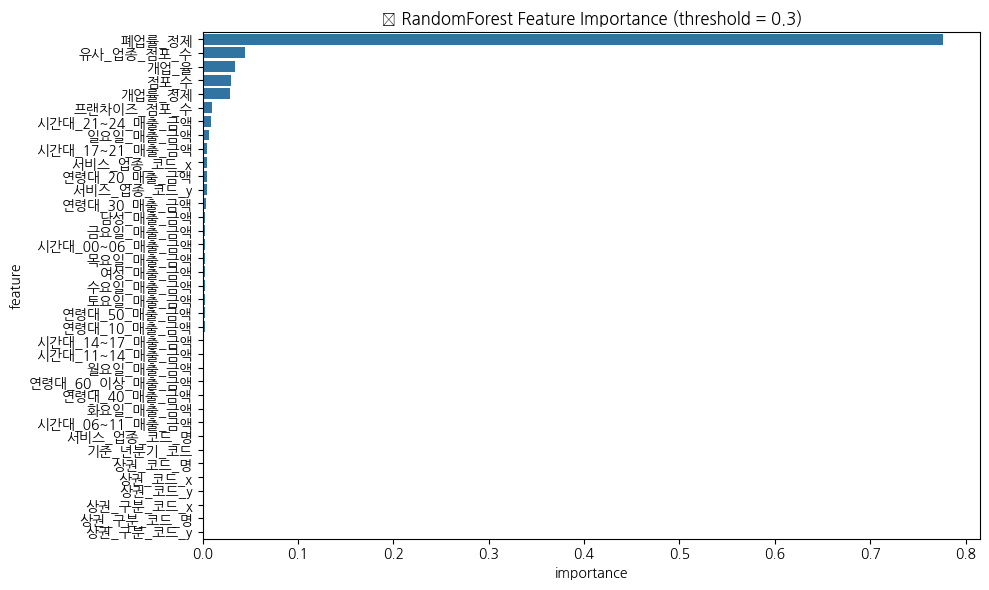


📈 LightGBM Feature Importance 시각화


/var/folders/69/bt3_5fns57n_cp5_ydbrhfh80000gn/T/ipykernel_20177/1596428088.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  plt.tight_layout()
/Users/giwonjun/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


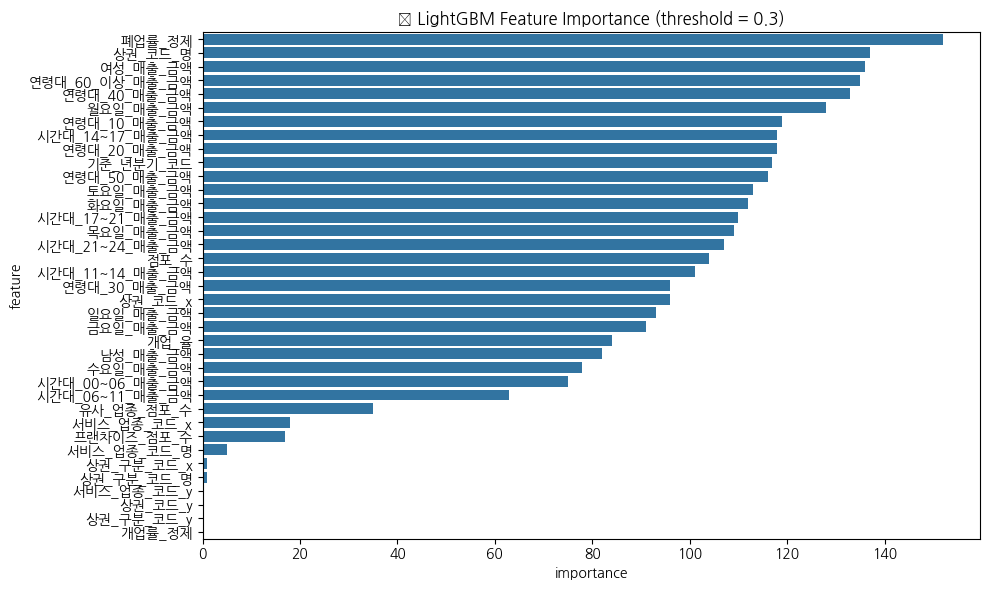


📈 XGBoost Feature Importance 시각화


/var/folders/69/bt3_5fns57n_cp5_ydbrhfh80000gn/T/ipykernel_20177/1596428088.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  plt.tight_layout()
/Users/giwonjun/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


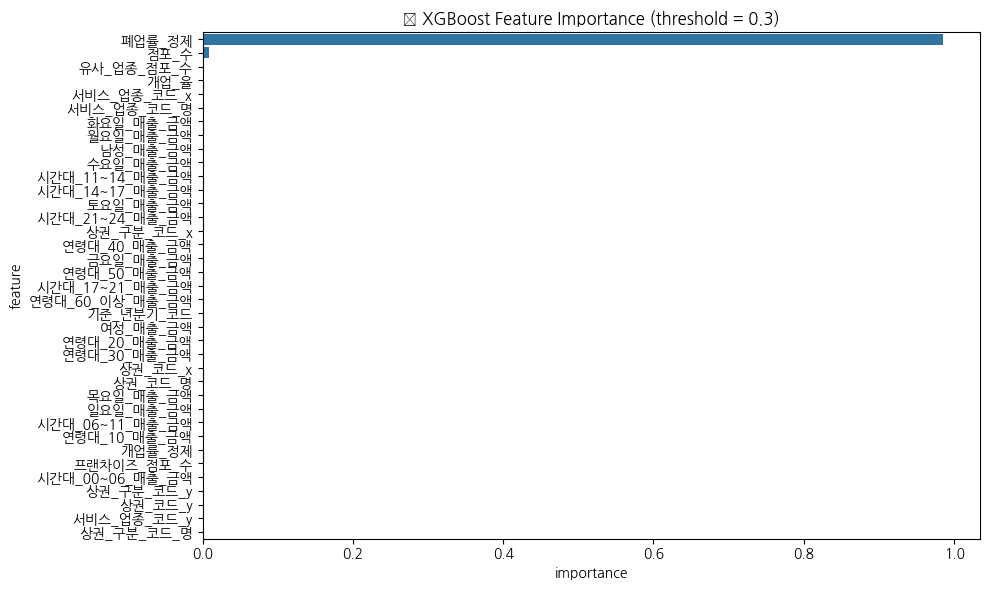

In [30]:
# 12. Feature importance 시각화

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#한글 깨짐 방지 설정
plt.rcParams['font.family'] = 'Nanum Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Feature Importance 시각화 함수
def plot_feature_importance(importances, feature_names, model_name="Model"):
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f"📊 {model_name} Feature Importance (threshold = {threshold})")
    plt.xlabel("importance")
    plt.ylabel("feature")
    plt.tight_layout()
    plt.show()

# 모델별 feature importance 시각화
for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        print(f"\n📈 {name} Feature Importance 시각화")
        importances = model.feature_importances_
        feature_names = X.columns
        plot_feature_importance(importances, feature_names, model_name=name)
